# Context managers

## The sad story of a neuroscientist and its electron microscope

Let's pretend we got an night slot to use a powerful scanning electron microscope SEM, and we want to use it to scan a brain sample.

We want to write a Python script to run during that slot that performs the scan automatically using the microscope API (so we can sleep instead of being at the lab).

First, we import what we need from the API:

In [1]:
from microscope import (
    MicroscopeState,  # Object that holds the current state of the microscope

    connect_to_microscope,   # Connect to microscope and get a state object
    release_microscope,

    make_void,  # Make void inside the microscope 
    release_void,
    
    insert_sample,  # Insert sample for scanning
    remove_sample,
    
    calibrate,  # Calibrate microscope
    scan_sample,  # What it says
)

This is the script that we came up with:

In [2]:
# To be run at 2AM using 'cron'
microscope_state = connect_to_microscope()
make_void(microscope_state)
calibration_image = calibrate(microscope_state)
sample_image = scan_sample(microscope_state)
release_void(microscope_state)
release_microscope(microscope_state)

Connected to microscope
Microscope under void
... done.


RuntimeError: Probe not present

Doh! We forgot to insert the brain sample.

That's horrible:

1) We still don't have the data

2) The void was not released and the void pump overheated over a few hours. The SEM is going to be offline for a couple of days until it's fixed :-(

We're not easily discouraged so we decide to fix the script:

In [3]:
# The script, complete
microscope_state = connect_to_microscope()
make_void(microscope_state)

insert_sample(microscope_state)
sample_image = scan_sample(microscope_state)
remove_sample(microscope_state)

release_void(microscope_state)
release_microscope(microscope_state)

Connected to microscope
Microscope under void
Probe inserted
Scanning probe...
... done.
Probe removed
Void released
Microscope released


Still, if anything goes wrong 1) the void pump might continue running or 2) the microscope connection might not be released, forcing some collagues to give up their slots.

What should we do to make sure that the microscope is always left in a decent state?

In [4]:
# The script, complete and safe
microscope_state = connect_to_microscope()

make_void(microscope_state)
try:
    insert_sample(microscope_state)
    try:
        sample_image = scan_sample(microscope_state)
    finally:
        remove_sample(microscope_state)
finally:
    release_void(microscope_state)

release_microscope(microscope_state)

Connected to microscope
Microscope under void
Probe inserted
Scanning probe...
... done.
Probe removed
Void released
Microscope released


Of course, we could define a function `safe_scan_image()` that does all of that and hides the complexity away, but the initial and final parts in the function will show up in a lot of similar functions (e.g. the one below). 

Plus, in general you want to pass in the microscope state for testing purposes.

In [5]:
# Script to collect a calibration image from the microscope.
microscope_state = connect_to_microscope()

make_void(microscope_state)
try:
    try:
        calibration_image = calibrate(microscope_state)
    finally:
        release_void(microscope_state)
finally:
    release_microscope(microscope_state)

Connected to microscope
Microscope under void
... done.
Void released
Microscope released


## How to define a context manager

We would like to write something like this:

```
with do_stuff_under_void(microscope_state):
    calibration_image = calibrate(microscope_state)
```

That is what context managers are for!

In [9]:
def do_stuff_under_void(microscope_state):
    make_void(microscope_state)
    try:
        return microscope_state
        # Here do some stuff with microscope_state
        # Come back here
    finally:
        release_void(microscope_state)

# But "return" makes the function quits... we've seen "yield" though!

We can use the `yield` keyword together with the `@contextmanager` to define a "context manager":

In [12]:
from contextlib import contextmanager

@contextmanager
def do_stuff_under_void(microscope_state):
    make_void(microscope_state)
    try:
        yield  # The control is returned, and a block of code is executed
        # The context manager continues from this point when the block of code exits
    finally:
        release_void(microscope_state)



In [13]:
microscope_state = connect_to_microscope()

with do_stuff_under_void(microscope_state):
    calibration_image = calibrate(microscope_state)

release_microscope(microscope_state)

Connected to microscope
Microscope under void
... done.
Void released
Microscope released


## Hands-on 1

Define a new context manager called `sample_inserted` that inserts a sample in the microscope before executing a block of code, and safely removes it at the end of the block.

Rewrite the brain-scan script using the `do_stuff_under_void` and the `sample_inserted` context managers


In [16]:
@contextmanager
def sample_inserted(microscope_state):
    insert_sample(microscope_state)
    try:
        yield
    finally:
        remove_sample(microscope_state)


microscope_state = connect_to_microscope()

with do_stuff_under_void(microscope_state):
    with sample_inserted(microscope_state):
        sample_image = scan_sample(microscope_state)

release_microscope(microscope_state)


Connected to microscope
Microscope under void
Probe inserted
Scanning probe...
... done.
Probe removed
Void released
Microscope released


## Context managers can return an initialized objects

Now that we're hooked to context managers, we would like to handle the connection to the microscope the same way.

In [20]:
@contextmanager
def microscope_connection():
    microscope_state = connect_to_microscope()
    try:
        yield microscope_state  # This allows the block to access this object
    finally:
        release_microscope(microscope_state)

with microscope_connection() as state:
    print('Is connected?', state.connected)
print('Is connected?', state.connected)

Connected to microscope
Is connected? True
Microscope released
Is connected? False


## Summing it all up

Summing it all up, a safe script to calibrate the microscope and take a brain sample could look like this:

In [21]:
@contextmanager
def microscope_connection():
    microscope_state = connect_to_microscope()
    try:
        yield microscope_state
    finally:
        release_microscope(microscope_state)

@contextmanager
def do_stuff_under_void(microscope_state):
    make_void(microscope_state)
    try:
        yield
    finally:
        release_void(microscope_state)

@contextmanager
def sample_inserted(microscope_state):
    insert_sample(microscope_state)
    try:
        yield
    finally:
        remove_sample(microscope_state)

        
with microscope_connection() as state:
    # Collect calibration image
    with do_stuff_under_void(state):
        calibration_image = calibrate(state)

    # Scan brain sample
    with do_stuff_under_void(state):
        with sample_inserted(state):
            sample_image = scan_sample(state)


Connected to microscope
Microscope under void
... done.
Void released
Microscope under void
Probe inserted
Scanning probe...
... done.
Probe removed
Void released
Microscope released


## Hands-on 2

Write a context manager called `temp_textfile` that takes a file name and creates a temporary text file with a given name. The file is deleted at the end of the block.

This is useful for testing: you don't want to leave files behind when the test fails! See also `tempfile.TemporaryFile`

In [ ]:
# ... write the `temp_textfile` context manager here

with temp_textfile('to_be_deleted.txt') as f:
    f.write('Hello world!')
    f.seek(0)
    print(f.read(5))

assert not os.path.exists('to_be_deleted.txt')

In [99]:
@contextmanager
def temp_textfile(filename):
    with open(filename, 'w+') as f:
        yield f
    os.remove(filename)
    
with temp_textfile('to_be_deleted.txt') as f:
    f.write('Hello world!')
    f.seek(0)
    print(f.read(5))

assert not os.path.exists('to_be_deleted.txt')

Hello


## Famous context managers

There are a few famous context managers that you should know about and use in your code!

### `open`

A classic: open a file and make sure that the file handle is released even if an error occurs.

In [33]:
with open('haiku.txt', 'w') as f:
    f.write('Out of memory.\nWe wish to hold the whole sky,\nBut we never will.\n')

with open('haiku.txt', 'r') as f:
    for line in f:
        print(line.strip())

Out of memory.
We wish to hold the whole sky,
But we never will.


### Matplotlib's `rc_context`

Temporarily set the matplotlib style options (see https://matplotlib.org/users/customizing.html). 

This is a common context manager pattern: temporary changes to the configuration of something.

Similarly: `pandas.option_context` 
(https://pandas.pydata.org/pandas-docs/stable/generated/pandas.option_context.html)

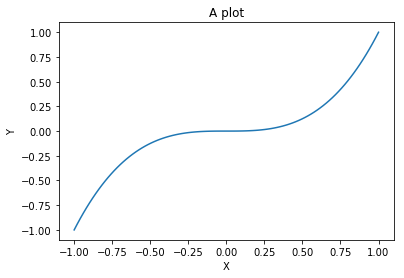

In [26]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-1, 1, 100)
y = x ** 3
plt.plot(x, y)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('A plot')

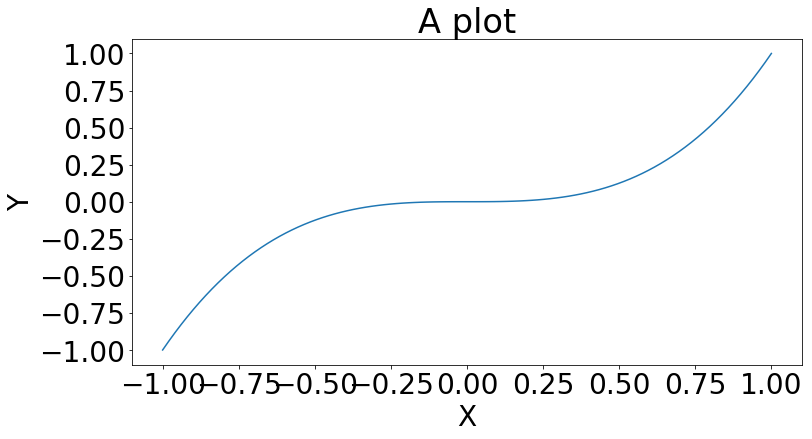

In [30]:
with plt.rc_context(rc={'figure.figsize': (12, 6), 'font.size': 28}):
    plt.plot(x, y)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('A plot')


### DB transactions

We can insert some values like this...

In [83]:
import sqlite3

conn = sqlite3.connect(':memory:')
conn.execute('CREATE TABLE users (id INT PRIMARY KEY, name CHAR(50))')

values = [(1, 'Pietro'), (2, 'Tiziano')]
for value in values:
    conn.execute('INSERT INTO users(id, name) VALUES (?, ?)', value)

result = conn.execute('SELECT * FROM users')
print(result.fetchall())

[(1, 'Pietro'), (2, 'Tiziano')]


But often we want to have a bloc of statements either succeed together, or not be executed at all. For example, in a bank transfer!

In [85]:
conn = sqlite3.connect(':memory:')
conn.execute('CREATE TABLE users (id INT PRIMARY KEY, name CHAR(50))')

values = [(1, 'Pietro'), (2, 'Tiziano'), 'Zbyszek']
for value in values:
    conn.execute('INSERT INTO users(id, name) VALUES (?, ?)', value)


ProgrammingError: Incorrect number of bindings supplied. The current statement uses 2, and there are 7 supplied.

In [86]:
result = conn.execute('SELECT * FROM users')
print(result.fetchall())

[(1, 'Pietro'), (2, 'Tiziano')]


Using `conn` as a context manager defines a DB transaction: if there is one error, all statements are rolled back and the DB does not change.

In [87]:
conn = sqlite3.connect(':memory:')
conn.execute('CREATE TABLE users (id INT PRIMARY KEY, name CHAR(50))')

values = [(1, 'Pietro'), (2, 'Tiziano'), 'Zbyszek']
with conn:
    for value in values:
        conn.execute('INSERT INTO users(id, name) VALUES (?, ?)', value)


ProgrammingError: Incorrect number of bindings supplied. The current statement uses 2, and there are 7 supplied.

In [88]:
result = conn.execute('SELECT * FROM users')
print(result.fetchall())

[]


### `contextlib.suppress`

`contextlib.suppress` suppresses one or more exceptions while the block of code is executed

In [91]:
from contextlib import suppress
import os

with suppress(FileNotFoundError):
    os.remove('haiku.txt')